In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline

pd.set_option('display.height', 1000)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.float_format',lambda x:'%.3f' % x)
%matplotlib inline
sns.set(style='whitegrid',context='notebook')
plt.rcParams['figure.figsize'] = (5, 5)

height has been deprecated.



In [7]:
df = pd.read_csv('./datasets/sequentialFirmIds.csv',index_col=0)

rm_col = ['firmsectionid','clientid','revenueid','processid','processtechnologyuseid',
          'financialsid','firmanalyticsresultid','RevenueBreakdownId',
          'OperatingExpensesId','OtherIncomeAndExpensesId','OperatingExpenseAdjustmentsId',
          'TotalNetRevenue','TotalOutstandingAssets',
          'ProjectedAnnualGrowthRate','RecurringRevenuePercent','TotalOutstandingLiabilities',
          'OtherPercent','ComparablesId','GrowthRateId','ExpenseRatioId',
          'DiscountFactorId','BusinessStabilityId','MarketStabilityId','ClientStabilityId',
          'ProFormaId','Year']
df.drop(rm_col,axis=1,inplace=True)
df = df[df.firmid != 346]
df = df.loc[df['NetRevenue']>=df['NetRevenue'].median()]
df['AnnualizedRevenueGrowth'] = df.apply(lambda x: np.nan, axis=1)

In [9]:
df.head()

,year,yearsinbusiness,firmid,employeecount,ClientsCount,AverageClientAge,AverageClientRelationshipLength,AverageClientAdditions,AverageClientDepartures,ReferralRate,InstitutionalAumPercent,TopFiveClientsAumPercent,BeneficiaryLevel,ClientMeetingFrequency,Aum,DiscretionaryInvestmentAumPercent,AverageBasisPointsForAdvisory,NonCompetes,SuccessionPlan,ManagementRetentionProgram,ContinuityPlan,CompensationBonusPlan,StockOwnershipPlan,TechnologyDisasterRecoveryPlan,RecentLegalIssues,CurrentLegalIssues,crm,accounting,portfoliomanagement,portfolioaccounting,financialplanning,firmwebsite,clientportal,socialmedia,email,digitalcompliancemonitoring,digitalfinancialrecords,robotechnology,riskassessmentsoftware,EquityPercent,FixedIncomePercent,MutualFundsPercent,MunicipalsPercent,CommoditiesPercent,ManagedMoneyPercent,InsurancePercent,AnnuityPercent,FinancialPlanningAndConsultingPercent,OtherServicesPercent,totaldirectexpense,othercompensationandbenefits,officeexpenses,rent,technology,professionalservices,marketingandbusinessdevelopment,travelandentertainment,insurance,other,depreciation,amortization,taxes,CashflowValue,NetBalanceSheet,TotalValue,NetRevenue,OperatingExpenses,IncomeFromOperations,Ebitda,Eboc,TruelyticsScore,DiscountRate,AnnualizedRevenueGrowth
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
6,2016,19.000,203,6,400,68,15,20,5,100.000,15.000,10.000,8.000,4.000,220000000.000,100.000,75.000,7,1,0,1,0,0,0,0,0,1,1,1,1,1,0,1,1,0,1,1,0,1,15.000,0.000,25.000,5.000,0.000,20.000,10.000,0.000,25.000,0.000,96000.000,51000.000,57900.000,21000.000,7800.000,1200.000,21766.000,4500.000,600.000,122698.000,9197.000,10401.000,36409.000,3986275.061,0.000,3986275.061,1443750.000,511050.000,932700.000,957000.000,1207000.000,3.055,28.900,nan
12,2014,34.000,205,7,220,55,12,10,3,50.000,0.000,30.000,30.000,2.000,320000000.000,100.000,0.000,0,0,1,0,0,1,0,0,0,1,1,1,0,1,0,1,0,0,0,0,0,0,0.000,0.000,0.000,0.000,0.000,80.000,0.000,0.000,20.000,0.000,375000.000,165000.000,33648.000,56100.000,71304.000,465816.000,25808.000,10500.000,5736.000,55000.000,2976.000,0.000,0.000,4407848.440,50000.000,4457848.440,2356000.000,1266888.000,1089112.000,1092088.000,1292088.000,2.445,31.300,nan
13,2016,36.000,205,7,250,55,12,10,3,50.000,0.000,30.000,5.000,2.000,320000000.000,100.000,0.000,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0.000,0.000,0.000,0.000,0.000,80.000,0.000,0.000,20.000,0.000,50000.000,1935500.000,212988.000,25000.000,50000.000,22500.000,10000.000,25000.000,8700.000,105000.000,2500.000,0.000,0.000,4357251.535,50000.000,4407251.535,2356000.000,1266888.000,1089112.000,1092088.000,1292088.000,2.500,31.800,nan
16,2014,11.000,207,16,12,52,8,3,1,80.000,100.000,40.000,100.000,4.000,190000000.000,0.000,0.000,0,1,0,1,1,1,0,0,0,1,1,1,1,0,1,0,1,1,1,1,0,0,0.000,0.000,0.000,0.000,0.000,100.000,0.000,0.000,0.000,0.000,600000.000,200000.000,25000.000,55000.000,35000.000,25000.000,8000.000,18000.000,10000.000,5500.000,4000.000,10401.000,36409.000,1129201.813,125000.000,1254201.813,1606000.000,1460089.000,145911.000,150240.000,330240.000,2.778,31.200,nan
17,2015,12.000,207,10,300,55,8,3,1,80.000,20.000,28.000,40.000,4.000,190000000.000,85.000,0.000,0,0,0,1,1,0,0,0,0,1,1,1,1,0,1,0,1,1,1,1,0,0,10.000,2.000,14.000,5.000,1.000,60.000,3.000,0.000,5.000,0.000,600000.000,200000.000,25000.000,55000.000,35000.000,25000.000,8000.000,18000.000,10000.000,5500.000,4000.000,10401.000,36409.000,2701257.245,0.000,2701257.245,1606000.000,985500.000,620500.000,634500.000,784500.000,2.778,30.900,nan


In [10]:
dict1 = {}
for i,row in df.iterrows():
    firmid = row['firmid']
    year = row['year']
    if firmid not in dict1:
        dict1[firmid] = []
        dict1[firmid].append(year)
    else:
        dict1[firmid].append(year)

In [11]:
firmids = []
for i,row in df.iterrows():
    firmids.append(row['firmid'])
    
firmids = sorted(list(set(firmids)))
    

In [12]:
for firmid in firmids:
    tempDf = df.loc[df['firmid']==firmid]
    years = dict1[firmid]
    
    #iterrate thru each row of the temporary df that includes only 1 firm
    for i,row in tempDf.iterrows():
        current_yr = row['year']
        if (current_yr-1) in years:
            net_rev0 = tempDf.loc[(tempDf['firmid']==firmid) &
                                  (tempDf['year']==(current_yr-1))].NetRevenue.item()
            net_rev1 = row['NetRevenue'].item()
            growth = (net_rev1-net_rev0)/net_rev0*100.0
            df.set_value(i,'AnnualizedRevenueGrowth',growth)

In [13]:
df.dropna(axis=0,how='any',inplace=True)

In [14]:
growth_mid = df['AnnualizedRevenueGrowth'].median()
aum_mid = df['Aum'].median()
print 'Total Revenue Growth Median: ',growth_mid
print 'AUM Median: ', aum_mid

Total Revenue Growth Median:  0.0
AUM Median:  320000000.0


In [15]:
cols = df.columns.tolist()[:62]
cols.remove('Aum')
cols.remove('firmid')

In [16]:
#Separate dataframe into category labels

#High revenue growth, high aum
df1 = df.loc[(df['AnnualizedRevenueGrowth']>growth_mid) & (df['Aum']>aum_mid)]

#High Revenue growth, low aum
df2 = df.loc[(df['AnnualizedRevenueGrowth']>growth_mid) & (df['Aum']<aum_mid)]

#low revenue growth, low aum
df3 = df.loc[(df['AnnualizedRevenueGrowth']<=growth_mid) & (df['Aum']<aum_mid)]

#low revenue growth, high aum
df4 = df.loc[(df['AnnualizedRevenueGrowth']<=growth_mid) & (df['Aum']>aum_mid)]

print df1.shape,df2.shape,df3.shape,df4.shape

(7, 73) (7, 73) (16, 73) (16, 73)


# High Growth Rate, High AUM 
## In predicting NetRevenue

High Growth Rate, High AUM R^2: 0.91823
High Growth Rate, High AUM MSE: 0.08177


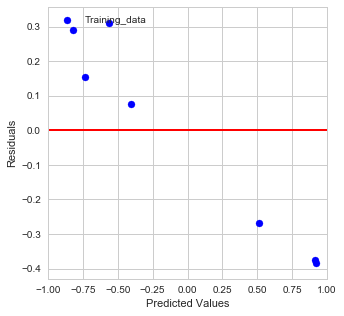

In [17]:
X = df1[cols].values.reshape(-1,len(cols))
y = df1['NetRevenue'].values.reshape(-1,1)
#y_aum = df1['Aum'].values.reshape(-1,1)
#y_growth = df1['TotalRevenueGrowth'].values.reshape(-1,1)

#standardize
sc = StandardScaler()
X_scl = sc.fit_transform(X)
y_scl = sc.fit_transform(y).reshape(-1)
#yAUM_scl = sc.fit_transform(y_aum).reshape(-1)
#yGRate_scl = sc.fit_transform(y_growth).reshape(-1)

forest = RandomForestRegressor(n_estimators=1000,
                               criterion='mse',
                               random_state=42,
                               n_jobs=-1,
                               oob_score=True)
forest.fit(X_scl,y_scl)
y_pred = forest.predict(X_scl)
print('High Growth Rate, High AUM R^2: %.5f' % r2_score(y_scl,y_pred))

print('High Growth Rate, High AUM MSE: %.5f' % mean_squared_error(y_scl,y_pred))

plt.scatter(y_pred,(y_pred-y_scl),c='blue',label='Training_data',marker='o')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.legend(loc='upper left')
plt.hlines(y=0,xmin=-1,xmax=1,color='red',lw=2)
plt.xlim([-1,1])
plt.show()

In [18]:
fts = forest.feature_importances_
ft_df = pd.DataFrame([],columns=['type','feature_importance'])
ft_df['type'] = cols
ft_df['feature_importance'] = fts
ft_df.sort_values('feature_importance',ascending=False)

,type,feature_importance
55,insurance,0.097
37,EquityPercent,0.078
1,yearsinbusiness,0.077
51,technology,0.064
13,DiscretionaryInvestmentAumPercent,0.056
52,professionalservices,0.048
54,travelandentertainment,0.038
41,CommoditiesPercent,0.034
15,NonCompetes,0.032
2,employeecount,0.032


# High Growth Rate, Low AUM 
## In predicting NetRevenue

High Growth Rate, Low AUM R^2: 0.89387
High Growth Rate, Low AUM MSE: 0.10613


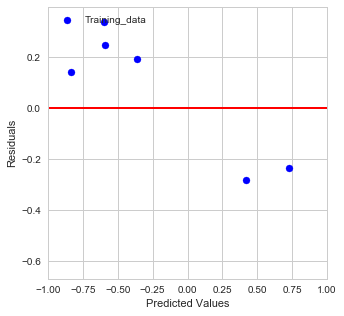

In [21]:
X = df2[cols].values.reshape(-1,len(cols))
y = df2['NetRevenue'].values.reshape(-1,1)
#y_aum = df2['Aum'].values.reshape(-1,1)
#y_growth = df2['TotalRevenueGrowth'].values.reshape(-1,1)

#standardize
sc = StandardScaler()
X_scl = sc.fit_transform(X)
y_scl = sc.fit_transform(y).reshape(-1)
#yAUM_scl = sc.fit_transform(y_aum).reshape(-1)
#yGRate_scl = sc.fit_transform(y_growth).reshape(-1)

forest = RandomForestRegressor(n_estimators=1000,
                               criterion='mse',
                               random_state=42,
                               n_jobs=-1,
                               oob_score=True)
forest.fit(X_scl,y_scl)
y_pred = forest.predict(X_scl)
print('High Growth Rate, Low AUM R^2: %.5f' % r2_score(y_scl,y_pred))

print('High Growth Rate, Low AUM MSE: %.5f' % mean_squared_error(y_scl,y_pred))

plt.scatter(y_pred,(y_pred-y_scl),c='blue',label='Training_data',marker='o')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.legend(loc='upper left')
plt.hlines(y=0,xmin=-1,xmax=1,color='red',lw=2)
plt.xlim([-1,1])
plt.show()

In [20]:
fts = forest.feature_importances_
ft_df = pd.DataFrame([],columns=['type','feature_importance'])
ft_df['type'] = cols
ft_df['feature_importance'] = fts
ft_df.sort_values('feature_importance',ascending=False)

,type,feature_importance
44,AnnuityPercent,0.122
48,othercompensationandbenefits,0.098
51,technology,0.091
0,year,0.042
7,AverageClientDepartures,0.040
59,taxes,0.038
6,AverageClientAdditions,0.034
5,AverageClientRelationshipLength,0.033
50,rent,0.032
11,BeneficiaryLevel,0.030


# Low Growth Rate, Low AUM 
## in predicting NetRevenue

Low Growth Rate, Low AUM R^2: 0.89403
Low Growth Rate, Low AUM MSE: 0.10597


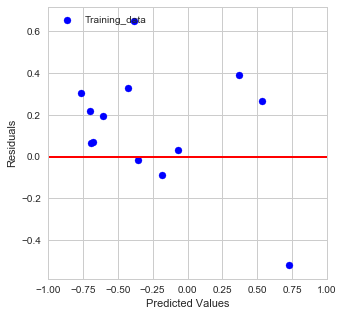

In [22]:
X = df3[cols].values.reshape(-1,len(cols))
y = df3['NetRevenue'].values.reshape(-1,1)
#y_aum = df3['Aum'].values.reshape(-1,1)
#y_growth = df3['TotalRevenueGrowth'].values.reshape(-1,1)

#standardize
sc = StandardScaler()
X_scl = sc.fit_transform(X)
y_scl = sc.fit_transform(y).reshape(-1)
#yAUM_scl = sc.fit_transform(y_aum).reshape(-1)
#yGRate_scl = sc.fit_transform(y_growth).reshape(-1)

forest = RandomForestRegressor(n_estimators=1000,
                               criterion='mse',
                               random_state=42,
                               n_jobs=-1,
                               oob_score=True)
forest.fit(X_scl,y_scl)
y_pred = forest.predict(X_scl)
print('Low Growth Rate, Low AUM R^2: %.5f' % r2_score(y_scl,y_pred))

print('Low Growth Rate, Low AUM MSE: %.5f' % mean_squared_error(y_scl,y_pred))

plt.scatter(y_pred,(y_pred-y_scl),c='blue',label='Training_data',marker='o')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.legend(loc='upper left')
plt.hlines(y=0,xmin=-1,xmax=1,color='red',lw=2)
plt.xlim([-1,1])
plt.show()

In [23]:
fts = forest.feature_importances_
ft_df = pd.DataFrame([],columns=['type','feature_importance'])
ft_df['type'] = cols
ft_df['feature_importance'] = fts
ft_df.sort_values('feature_importance',ascending=False)

,type,feature_importance
37,EquityPercent,0.377
53,marketingandbusinessdevelopment,0.088
8,ReferralRate,0.070
13,DiscretionaryInvestmentAumPercent,0.070
5,AverageClientRelationshipLength,0.052
45,FinancialPlanningAndConsultingPercent,0.047
55,insurance,0.031
42,ManagedMoneyPercent,0.029
52,professionalservices,0.024
7,AverageClientDepartures,0.021


# Low Growth Rate, High AUM 
## in predicting NetRevenue

Low Growth Rate, High AUM R^2: 0.86505
Low Growth Rate, High AUM MSE: 0.13495


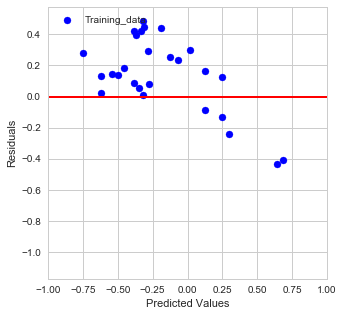

In [36]:
X = df4[cols].values.reshape(-1,len(cols))
y = df4['NetRevenue'].values.reshape(-1,1)
#y_aum = df4['Aum'].values.reshape(-1,1)
#y_growth = df4['TotalRevenueGrowth'].values.reshape(-1,1)

#standardize
sc = StandardScaler()
X_scl = sc.fit_transform(X)
y_scl = sc.fit_transform(y).reshape(-1)
#yAUM_scl = sc.fit_transform(y_aum).reshape(-1)
#yGRate_scl = sc.fit_transform(y_growth).reshape(-1)

forest = RandomForestRegressor(n_estimators=1000,
                               criterion='mse',
                               random_state=42,
                               n_jobs=-1,
                               oob_score=True)
forest.fit(X_scl,y_scl)
y_pred = forest.predict(X_scl)
print('Low Growth Rate, High AUM R^2: %.5f' % r2_score(y_scl,y_pred))

print('Low Growth Rate, High AUM MSE: %.5f' % mean_squared_error(y_scl,y_pred))

plt.scatter(y_pred,(y_pred-y_scl),c='blue',label='Training_data',marker='o')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.legend(loc='upper left')
plt.hlines(y=0,xmin=-1,xmax=1,color='red',lw=2)
plt.xlim([-1,1])
plt.show()

In [37]:
fts = forest.feature_importances_
ft_df = pd.DataFrame([],columns=['type','feature_importance'])
ft_df['type'] = cols
ft_df['feature_importance'] = fts
ft_df.sort_values('feature_importance',ascending=False)

,type,feature_importance
2,employeecount,0.145
3,ClientsCount,0.102
46,OtherServicesPercent,0.101
1,yearsinbusiness,0.067
10,TopFiveClientsAumPercent,0.063
8,ReferralRate,0.051
55,insurance,0.048
53,marketingandbusinessdevelopment,0.048
36,riskassessmentsoftware,0.036
48,othercompensationandbenefits,0.028
